In [1]:
%pylab inline
import numpy as np
from tqdm import trange
np.set_printoptions(suppress=True)

Populating the interactive namespace from numpy and matplotlib


In [2]:
def fetch(url):
  import requests, gzip, os, hashlib, numpy
  fp = os.path.join("/Users/brendanglancy/Downloads/t10k-images.idx3-ubyte")
  if not os.path.isfile(fp):
    with open(fp, "rb") as f:
      dat = f.read()
  else:
    with open(fp, "wb") as f:
      dat = requests.get(url).content
      f.write(dat)
  return numpy.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

X_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
X_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
Y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]



In [3]:
# Visualization of the Mnist dataset

G = 30
grid = sorted(list(zip(ret, range(ret.shape[0]))), reverse=False)[0:G*G]
X_bad = X_test[[x[1] for x in grid]]
figsize(8,12)
imshow(np.concatenate(X_bad.reshape((G, 28*G, 28)), axis=1))

NameError: name 'ret' is not defined

In [4]:
# model
import torch
import torch.nn as nn
import torch.nn.functional as F
torch.set_printoptions(sci_mode=False)

class Bnet(torch.nn.Module):
  def __init__(self):
    super(Bnet, self).__init__()
    self.l1 = nn.Linear(784, 128, bias=False)
    self.l2 = nn.Linear(128, 10, bias=False)
    self.sm = nn.LogSoftmax(dim=1)
  def forward(self, x):
    x = F.relu(self.l1(x))
    x = self.l2(x)
    x = self.sm(x)
    return x
    
    # Instantiate a Bnet


In [ ]:
# Training
model = Bnet()

loss_function = nn.NLLLoss(reduction='none')
optim = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0)
BS = 128
losses, accuracies = [], []

for i in (t := trange(1000)):
    samp = np.random.randint(0, X_train.shape[0], size=(BS))
    X = torch.tensor(X_train[samp].reshape((-1, 28*28))).float()
    Y = torch.tensor(Y_train[samp]).long()
    model.zero_grad()
    out = model(X)
    cat = torch.argmax(out, dim=1)
    accuracy = (cat == Y).float().mean()
    loss = loss_function(out, Y)
    loss = loss.mean()
    loss.backward()
    optim.step()
    loss, accuracy = loss.item(), accuracy.item()
    losses.append(loss)
    accuracies.append(accuracy)
    figsize(10,4)
    t.set_description("loss %.2f accuracy %.2f" % (loss, accuracy))
plt.ylim(-0.1, 1.1)
plot(losses)
plot(accuracies)

loss 0.15 accuracy 0.95: 100%|██████████| 1000/1000 [00:03<00:00, 313.30it/s]


In [316]:
# evalutation

Y_test_preds = torch.argmax(model(torch.tensor(X_test.reshape((-1, 28*28))).float()), dim=1).numpy()
(Y_test == Y_test_preds).mean()

0.9629

tensor([19.0566], grad_fn=<NllLossBackward>)


(tensor([1.]), tensor([[ 0., -1.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]]))

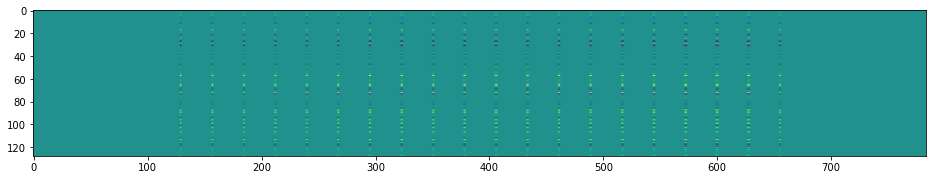

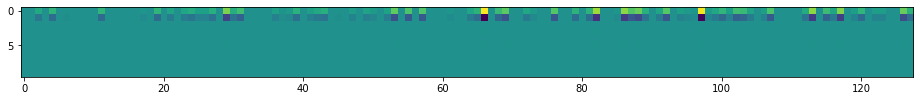

In [317]:
# compute gradients in torch
model = Bnet()


# understand gradients
samp = [2]
model.zero_grad()
out = model(torch.tensor(X_test[samp].reshape((-1, 28*28))).float())
out.retain_grad()
loss = loss_function(out, torch.tensor(Y_test[samp]).long())
print(loss)
loss.retain_grad()
loss.backward()
figsize(16,16)
imshow(model.l1.weight.grad)
figure()
imshow(model.l2.weight.grad)
loss.grad, out.grad

In [325]:



# init the network
l1 = np.zeros((784, 128), dtype=np.float32)
l2 = np.zeros((128, 10), dtype=np.float32)

# copy weights from pytorch
l1[:] = model.l1.weight.detach().numpy().T
l2[:] = model.l2.weight.detach().numpy().T

# numpy forward pass
def forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)  
    return x
Y_test_preds_out = forward(X_test.reshape((-1, 28*28)))
Y_test_preds = np.argmax(Y_test_preds_out, axis=1)
(Y_test == Y_test_preds).mean()

0.1077

In [332]:
Y_test_preds_out[0]

array([ 16.839676  ,  -4.705859  ,   5.5863295 ,  -0.61504453,
         8.24751   ,   6.882415  ,  -7.891814  ,  -5.1189747 ,
         2.1959898 , -14.754434  ], dtype=float32)

(1, 784) (1, 128) (1, 128) (1, 10)
[[ 28.28745    -5.373796  -18.650276  -53.65828    18.60991    -1.8941861
  -23.637915   -2.2634218   0.0000937  26.252645 ]]
tensor([[0., 0., 1., 0., 0., 0., 0., 0., 0., 0.]])
[[ 0.08843558  0.         -0.1         0.          0.00000554  0.
   0.          0.          0.          0.01155888]]
(128, 10)


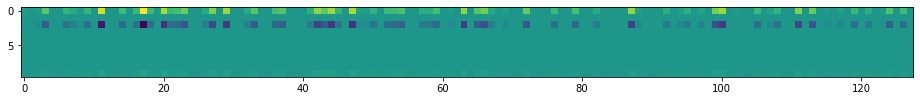

In [337]:
# training
# forward pass

x = X_test[1:2].reshape((-1, 28*28))
x_l1 = x.dot(l1)
x_relu = np.maximum(x_l1, 0)

# w=x_relu(1,128), x=12(128,10)
x_l2 = x_relu.dot(l2)
print(x.shape, x_l1.shape, x_relu.shape, x_l2.shape)

# training in numpy
# backward passing

out = np.zeros((1,10), np.float32)
out[0,2] = 1
out = torch.tensor(out)

# derivative of logofsoftmax
# Will involve x_l2, out, produces dx_sm
# 

gin = torch.tensor(Y_test_preds_out[1:2], requires_grad=True)
gout = torch.nn.functional.log_softmax(gin, dim=1)
loss = (-out * gout).mean()
loss.backward()
dx_sm = gin.grad.numpy()

print(x_l2)
print(out)
print(dx_sm)

# Derivative of l2
d_l2 = x_relu.T.dot(dx_sm)
dx_relu = dx_sm.dot(l2.T)

# Derivative of l1
d_l1 = x_relu.T.dot(dx_sm)

# Derivative of relu
dx_l1 = (x_relu > 0).astype(np.float32) * dx_relu

# Numpy doing the same thing as torch
print(d_l2.shape)

imshow(d_l2.T)

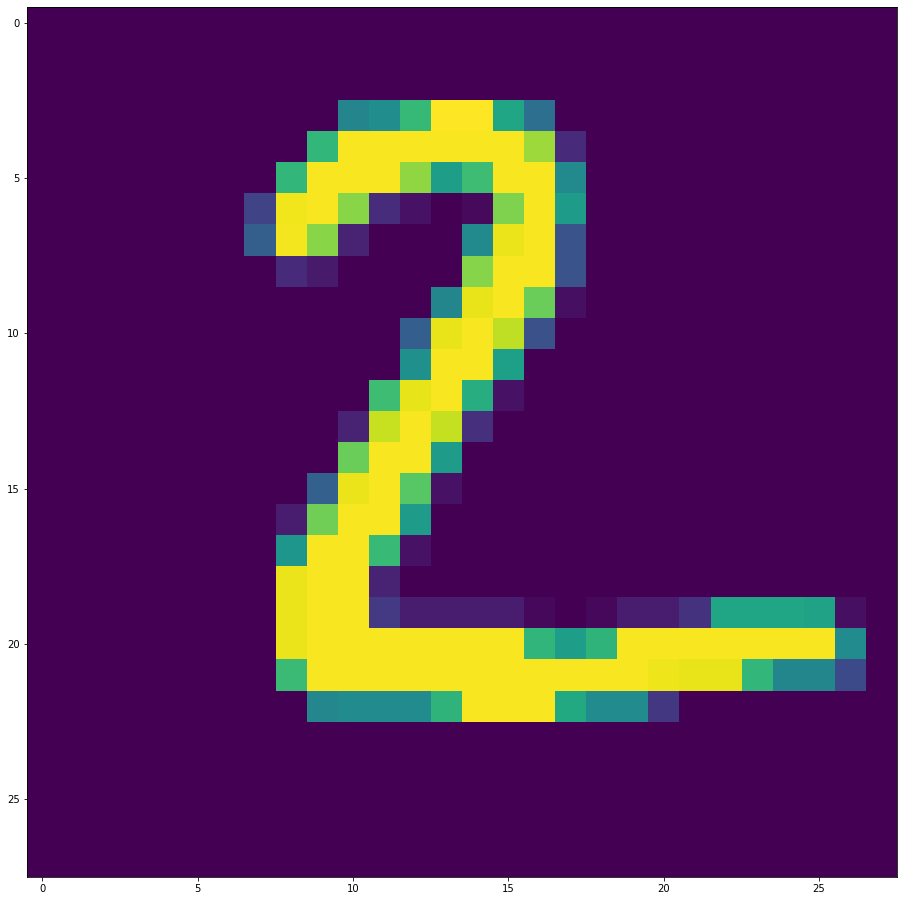

In [309]:
imshow(X_test[1])